In [1]:
import numpy as np

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer

import os
import copy
from itertools import cycle, combinations

import sys
sys.path.append('../..')

import backpack

In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../dataset'
dm = LocalDataManager(None)

cfg = load_config_data('./config.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()

In [4]:
def map_frame_array_to_dict(array):
    return dict(zip(['timestamp', 'agent_index_interval', 'ego_translation', 'ego_rotation'], array))

def map_scene_array_to_dict(array):
    return dict(zip(['frame_index_interval', 'host', 'start_time', 'end_time'], array))

def map_agent_array_to_dict(array):
    return dict(zip(['centroid', 'extent', 'yaw', 'velocity', 'track_id', 'label_probabilities'], array))

In [5]:
scenes = [map_scene_array_to_dict(s) for s in train_zarr.scenes]
frames = [map_frame_array_to_dict(f) for f in train_zarr.frames]
agents = [map_agent_array_to_dict(a) for a in train_zarr.agents]

In [10]:
# playing around with scene 99
scene_i = 99
scene = scenes[scene_i]
scene

{'frame_index_interval': array([24590, 24838]),
 'host': 'host-a101',
 'start_time': 1571844710505151232,
 'end_time': 1571844735505151232}

In [11]:
clusters = []

fii = scene['frame_index_interval']
for frame in frames[fii[0]: fii[1]]:
    
    c = backpack.Cluster(frame, agents)
    c.normalize_data()
    
    clusters.append(c)

[{14: {16: 24.88595441804489}, 16: {14: 24.88595441804489}},
 {21: {23: 15.579209500985444, 24: 28.1823500526166, 25: 23.18987947572863},
  23: {21: 15.579209500985444, 24: 29.190944695232158, 25: 6.475880361812096},
  24: {21: 28.1823500526166, 23: 29.190944695232158, 25: 32.058439367794804},
  25: {21: 23.18987947572863, 23: 6.475880361812096, 24: 32.058439367794804}},
 {29: {30: 1.4005384714639422,
   31: 15.943837573236447,
   32: 10.962816038735635,
   33: 18.647122978838862,
   34: 27.260815696971623,
   35: 22.70846267885645,
   36: 27.603626996278763,
   37: 34.059805406702196,
   38: 30.22207065951282,
   39: 37.812675147496414,
   40: 37.436884881079095,
   41: 38.97384965472665,
   42: 43.12850528420537,
   43: 48.66233293712139,
   44: 48.68939885497093,
   45: 41.058035442455676,
   46: 49.200597640173875,
   47: 52.02234360660077,
   48: 44.45186542631476,
   49: 43.60984912041601,
   50: 41.03909832397978,
   51: 34.72240744107157,
   52: 38.07779008275521,
   53: 39.388

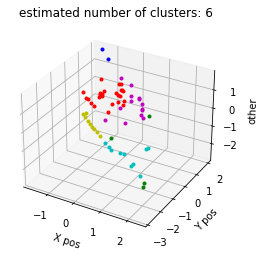

In [12]:
clusters[0].kmeans_cluster(n_clusters=6)
clusters[0].plot()
clusters[0].generate_distance_matrixes()